<a href="https://colab.research.google.com/github/smjason0502/python-deep-learning-pytorch/blob/main/4%EC%A3%BC%EC%B0%A8_%EC%8A%A4%ED%84%B0%EB%94%94(%ED%8C%8C%EC%9D%B4%EC%8D%AC__%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [예제 4-1] CIFAR-10 데이터 이용해 Multi Layer Perceptron(MLP) 설계하기

In [ ]:
# 1. module import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
# 2. 딥러닝 모델 설계 시 활용 장비 확인
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)
# Using PyTorch version: 1.5.0+cu101 Device: cuda

Using PyTorch version: 2.4.1+cu121 Device: cpu


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
#3. CIFAR10 데이터 다운로드(Train set, Test set 분리)
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                               train = False,
                               transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 170498071/170498071 [00:10<00:00, 16024547.28it/s]


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [ ]:
#4. 데이터 확인(1)
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size( ), 'type:', X_train.type())
  print('y_train:', y_train.size( ), 'type:', y_train.type())
  break

## X_train: torch. Size([32, 3, 32, 32]) type: torch.FloatTensor
## y_train: torch. Size([32]) type: torch.LongTensor

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


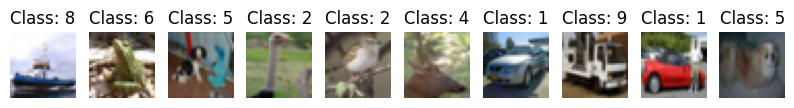

In [ ]:
# 5. 데이터 확인하기(2)
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis ('off')
  plt.imshow(np.transpose(X_train[i],(1,2,0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
# 6. MLP(Multi Layer Perceptron) 모델 설계

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(32*32*3, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = x.view(-1, 32 * 32 * 3)
    x = self.fc1(x)
    x = F.relu(x)

    x = self.fc2(x)
    x = F.relu(x)

    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    return x

In [ ]:
# 7. Optimizer, Objective Function 설정하기

model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

# Net (
#    (fc1) Linear(in_features=784, out_features=512, bias=True)
#    (fc2) Linear(in_features=512, out_features=256, bias=True)
#    (fc3) Linear(in_features=256, out_features=10, bias=True)
# )


Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
# 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx,(image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))

In [ ]:

# 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct =0

    with torch.no_grad():
      for image, label in test_loader:
          image = image.to(DEVICE)
          label = label.to(DEVICE)
          output = model(image)
          test_loss += criterion(output, label).item()
          prediction = output.max(1, keepdim = True)[1]
          correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


In [ ]:
# 10. MLP 학습을 실행하며 Train , Test set의 Loss 및 Test set Accuracy를 확인
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
          format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.305684
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.940948
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 2.225945
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.602637
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.560904
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.859074
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.536332
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.675193

[EPOCH: 1], 	Test Loss: 0.0531, 	Test Accuracy: 38.43 %

Train Epoch: 2 [0/50000(0%)]	Train Loss: 1.758455
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.637225
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.554496
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.921081
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.977284
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.701655
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.404687
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.513639

[EPOCH: 2], 	Test Loss: 0.0500, 	Test Accuracy: 43.27 %

Train Epoch: 3 [

#[예제4-2] CIFAR-10 데이터를 이용해 Convolutional Neural Network(CNN)설계하기


In [ ]:
# 1. module import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
# 2. 딥러닝 모델 설계 시 활용 장비 확인
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)
# Using PyTorch version: 1.5.0+cu101 Device: cuda

Using PyTorch version: 2.4.1+cu121 Device: cpu


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
#3. CIFAR10 데이터 다운로드(Train set, Test set 분리)
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                               train = False,
                               transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [ ]:
#4. 데이터 확인(1)
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size( ), 'type:', X_train.type())
  print('y_train:', y_train.size( ), 'type:', y_train.type())
  break

## X_train: torch. Size([32, 3, 32, 32]) type: torch.FloatTensor
## y_train: torch. Size([32]) type: torch.LongTensor

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


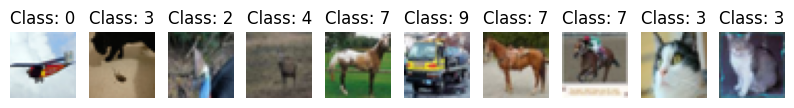

In [ ]:
# 5. 데이터 확인하기(2)
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis ('off')
  plt.imshow(np.transpose(X_train[i],(1,2,0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
# 6. CNN(Convolutional Neural Network) 모델 설계

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(
        in_channels = 3,
        out_channels = 8,
        kernel_size = 3,
        padding =1)
    self.conv2 = nn.Conv2d(
        in_channels = 8,
        out_channels = 16,
        kernel_size = 3,
        padding =1)
    self.pool = nn.MaxPool2d(
        kernel_size = 2,
        stride =2)
    self.fc1 = nn.Linear(8*8*16, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)

    x = x.view(-1, 8 * 8 * 16)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.log_softmax(x)
    return x

In [ ]:
# 7. Optimizer, Objective Function 설정하기

model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

# Net (
#    (fc1) Linear(in_features=784, out_features=512, bias=True)
#    (fc2) Linear(in_features=512, out_features=256, bias=True)
#    (fc3) Linear(in_features=256, out_features=10, bias=True)
# )


Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
# 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx,(image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))

In [ ]:
# 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct =0

    with torch.no_grad():
      for image, label in test_loader:
          image = image.to(DEVICE)
          label = label.to(DEVICE)
          output = model(image)
          test_loss += criterion(output, label).item()
          prediction = output.max(1, keepdim = True)[1]
          correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


In [ ]:
# 10. MLP 학습을 실행하며 Train , Test set의 Loss 및 Test set Accuracy를 확인
for Epoch in range(1,EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
          format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.315614
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.863046
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.968138
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 2.313465
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.534825
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 2.204509
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.661923
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.711978

[EPOCH: 1], 	Test Loss: 0.0541, 	Test Accuracy: 37.52 %

Train Epoch: 2 [0/50000(0%)]	Train Loss: 1.834213
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 2.073775
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.964701
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.620500
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.426276
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.716867
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.404718
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.392380

[EPOCH: 2], 	Test Loss: 0.0500, 	Test Accuracy: 42.92 %

Train Epoch: 3 [

# [예제4-3] CIFAR-10 데이터에 Augmentation 기법을 이용해 모델의 성능 향상시키기


In [ ]:
# 1. module import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
# 2. 딥러닝 모델 설계 시 활용 장비 확인
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)
# Using PyTorch version: 1.5.0+cu101 Device: cuda

Using PyTorch version: 2.4.1+cu121 Device: cpu


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
#3. Data Augmentation 적용된 CIFAR10 데이터 다운로드(Train set, Test set 분리)

train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                               train = True,
                               download = True,
                               transform = transforms.Compose([
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,0.5,0.5),
                                   (0.5,0.5,0.5))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                               train = False,
                               transform = transforms.Compose([
                               transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,0.5,0.5),
                                   (0.5,0.5,0.5))]))


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [ ]:
#4. 데이터 확인(1)
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size( ), 'type:', X_train.type())
  print('y_train:', y_train.size( ), 'type:', y_train.type())
  break

## X_train: torch. Size([32, 3, 32, 32]) type: torch.FloatTensor
## y_train: torch. Size([32]) type: torch.LongTensor

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


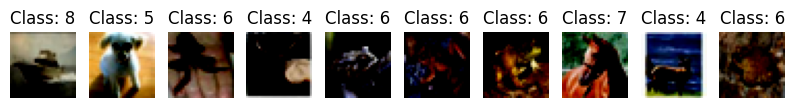

In [ ]:
# 5. 데이터 확인하기(2)
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis ('off')
  plt.imshow(np.transpose(X_train[i],(1,2,0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
# 6. MLP(Multi Layer Perceptron) 모델 설계

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(32*32*3, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = x.view(-1, 32 * 32 * 3)
    x = self.fc1(x)
    x = F.relu(x)

    x = self.fc2(x)
    x = F.relu(x)

    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    return x

In [ ]:
# 7. Optimizer, Objective Function 설정하기

model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

# Net (
#    (fc1) Linear(in_features=784, out_features=512, bias=True)
#    (fc2) Linear(in_features=512, out_features=256, bias=True)
#    (fc3) Linear(in_features=256, out_features=10, bias=True)
# )


Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
# 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx,(image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))

In [ ]:
# 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct =0

    with torch.no_grad():
      for image, label in test_loader:
          image = image.to(DEVICE)
          label = label.to(DEVICE)
          output = model(image)
          test_loss += criterion(output, label).item()
          prediction = output.max(1, keepdim = True)[1]
          correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


In [ ]:
# 10. MLP 학습을 실행하며 Train , Test set의 Loss 및 Test set Accuracy를 확인
for Epoch in range(1,EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
    format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.302849
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.686178
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.491226
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.586158
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.761520
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 2.035388
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 2.040009
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.813178

[EPOCH: 1], 	Test Loss: 0.0478, 	Test Accuracy: 45.75 %

Train Epoch: 2 [0/50000(0%)]	Train Loss: 1.755304
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.339910
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.191593
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.836809
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.330683
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.227121
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.435548
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.448776

[EPOCH: 2], 	Test Loss: 0.0458, 	Test Accuracy: 47.58 %

Train Epoch: 3 [

#[예제4-4] CIFAR-10 데이터에 고급 Convolutional Neural Network 모델을 적용해 성능 향상시키기


In [ ]:
# 1. module import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
# 2. 딥러닝 모델 설계 시 활용 장비 확인
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)
# Using PyTorch version: 1.5.0+cu101 Device: cuda

Using PyTorch version: 2.4.1+cu121 Device: cpu


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
#3. CIFAR10 데이터 다운로드(Train set, Test set 분리)
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                               train = False,
                               transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [ ]:
#4. 데이터 확인(1)
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size( ), 'type:', X_train.type())
  print('y_train:', y_train.size( ), 'type:', y_train.type())
  break

## X_train: torch. Size([32, 3, 32, 32]) type: torch.FloatTensor
## y_train: torch. Size([32]) type: torch.LongTensor

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


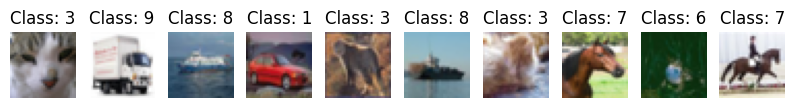

In [ ]:
# 5. 데이터 확인하기(2)
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis ('off')
  plt.imshow(np.transpose(X_train[i],(1,2,0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
# 6. ResNet 모델 설계
# ResNet 모델은 내부에 반복적으로 이용하는 Block을 바탕으로 구성

class BasicBlock(nn.Module):
  def __init__(self, in_planes, planes, stride = 1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes,
        kernel_size = 3,
        stride = stride,
        padding = 1,
        bias = False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes,
        kernel_size = 3,
        stride = 1,
        padding =1,
        bias = False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_planes, planes,
                    kernel_size = 1,
                    stirde = stride,
                    bias = False),
          nn.BatchNorm2d(planes))

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, num_classes = 10):
    super(ResNet, self).__init__()
    self.in_planes = 16

    self.conv1 = nn.Conv2d(3, 16,
                           kernel_size = 3,
                           stride = 1,
                           padding = 1,
                           bias = False)
    self.bn1 = nn.BatchNorm2d(16)
    self.layer1 = self._make_layer(16,2,stride=1)
    self.layer2 = self._make_layer(32,2,stride=2)
    self.layer3 = self._make_layer(64,2,stride=2)
    self.linear = nn.Linear(64, num_classes)

  def make_layer(self,planes,num_blocks,stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stide in strides:
      layers.append(BasicBlock(self.in_planes, planes, stride))
      self.in_planes = planes
    return nn.Sequential(*layers)

  def forward(self,x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = F.avg_pool2d(out, 8)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

In [ ]:
# 7. Optimizer, Objective Function 설정하기

model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

# Net (
#    (fc1) Linear(in_features=784, out_features=512, bias=True)
#    (fc2) Linear(in_features=512, out_features=256, bias=True)
#    (fc3) Linear(in_features=256, out_features=10, bias=True)
# )


Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
# 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx,(image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))

In [ ]:
# 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct =0

    with torch.no_grad():
      for image, label in test_loader:
          image = image.to(DEVICE)
          label = label.to(DEVICE)
          output = model(image)
          test_loss += criterion(output, label).item()
          prediction = output.max(1, keepdim = True)[1]
          correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


In [ ]:
# 10. MLP 학습을 실행하며 Train , Test set의 Loss 및 Test set Accuracy를 확인
for Epoch in range(1,EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
    format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.299913
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 2.001451
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.953109
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 2.028984
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.680089
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 2.029781
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.896943
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.839601

[EPOCH: 1], 	Test Loss: 0.0548, 	Test Accuracy: 37.40 %

Train Epoch: 2 [0/50000(0%)]	Train Loss: 1.542321
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.477510
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.817630
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 2.041057
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.378478
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.566309
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.369925
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.704204

[EPOCH: 2], 	Test Loss: 0.0506, 	Test Accuracy: 41.89 %

Train Epoch: 3 [

# [예제 4-5] CIFAR-10 데이터에 대표적인 딥러닝 모델을 불러와 적용

In [ ]:
# 1. module import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
# 2. 딥러닝 모델 설계 시 활용 장비 확인
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)
# Using PyTorch version: 1.5.0+cu101 Device: cuda

Using PyTorch version: 2.4.1+cu121 Device: cpu


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
#3. CIFAR10 데이터 다운로드(Train set, Test set 분리)
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                               train = False,
                               transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 170498071/170498071 [00:02<00:00, 64507635.12it/s]


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [ ]:
#4. 데이터 확인(1)
for (X_train, y_train) in train_loader:
  print('X_train:', X_train.size( ), 'type:', X_train.type())
  print('y_train:', y_train.size( ), 'type:', y_train.type())
  break

## X_train: torch. Size([32, 3, 32, 32]) type: torch.FloatTensor
## y_train: torch. Size([32]) type: torch.LongTensor

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


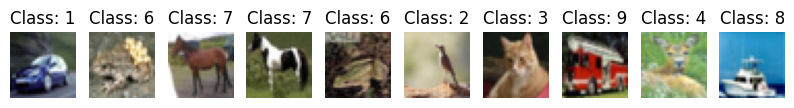

In [ ]:
# 5. 데이터 확인하기(2)
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis ('off')
  plt.imshow(np.transpose(X_train[i],(1,2,0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
# 6. 파이토치 내에서 제공 ResNet34 모델 불러온 후 FC 층 추가 및 Output 크기 설정
import torchvision.models as models
model = models.resnet34(pretrained = False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.to(DEVICE)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 7. Optimizer, Objective Function 설정하기

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

# Net (
#    (fc1) Linear(in_features=784, out_features=512, bias=True)
#    (fc2) Linear(in_features=512, out_features=256, bias=True)
#    (fc3) Linear(in_features=256, out_features=10, bias=True)
# )


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx,(image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss. backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))

In [ ]:
# 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct =0

    with torch.no_grad():
      for image, label in test_loader:
          image = image.to(DEVICE)
          label = label.to(DEVICE)
          output = model(image)
          test_loss += criterion(output, label).item()
          prediction = output.max(1, keepdim = True)[1]
          correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


In [ ]:
# 10. MLP 학습을 실행하며 Train , Test set의 Loss 및 Test set Accuracy를 확인
for Epoch in range(1,EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
    format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.507754
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.444019
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.434255
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.476769
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.180623
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.032437
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.599675
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 0.786230

[EPOCH: 1], 	Test Loss: 0.0462, 	Test Accuracy: 49.85 %

Train Epoch: 2 [0/50000(0%)]	Train Loss: 1.218210
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.618136
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 0.975216
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.069453
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 0.715828
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 1.231046
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.303109
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 0.913064

[EPOCH: 2], 	Test Loss: 0.0329, 	Test Accuracy: 62.27 %

Train Epoch: 3 [

In [ ]:
# 11. ImageNet 데이터로 학습된 ResNet34 모델 불러온 후 Fine-tuning 해보기
import torchvision.models as models
model = models.resnet34(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

for Epoch in range(1,EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
    format(Epoch, test_loss, test_accuracy))


#[예제 4-6] 대용량의 데이터를 이용해 학습이 완료된 모델을 적은 수의 데이터에 맞게 Fine- tuning하는 Transfer Learning 실습하기

In [ ]:
# 1. module import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
# 2. 딥러닝 모델 설계 시 활용 장비 확인
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)
# Using PyTorch version: 1.5.0+cu101 Device: cuda

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
#3. 개미와 벌을 분류하기 위해 개미 이미지 데이터와 벌 이미지 데이터 불러오기(Train set, Test set 분리)

data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224)
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),

    'val' = transforms.Compose([
        transforms.CenterCrop(224)
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
}


image_datasets = {x: datasets.ImageFolder("../data/hymenoptera_data",
    data_transforms[x]) for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
    batch_size = BATCH_SIZE,
    num_workers = 0,
    shuffle = True) for x in ['train','val']}

In [ ]:
#4. 데이터 확인(1)
for (X_train, y_train) in dataloaders['train']:
  print('X_train:', X_train.size( ), 'type:', X_train.type())
  print('y_train:', y_train.size( ), 'type:', y_train.type())
  break

## X_train: torch. Size([32, 3, 224, 224]) type: torch.FloatTensor
## y_train: torch. Size([32]) type: torch.LongTensor

In [ ]:
# 5. 데이터 확인하기(2)
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i + 1)
  plt.axis ('off')
  plt.imshow(np.transpose(X_train[i],(1,2,0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
# 6. 불러온 특정 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx,(image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss. backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))

In [ ]:
# 7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct =0

    with torch.no_grad():
      for image, label in test_loader:
          image = image.to(DEVICE)
          label = label.to(DEVICE)
          output = model(image)
          test_loss += criterion(output, label).item()
          prediction = output.max(1, keepdim = True)[1]
          correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


In [ ]:
# 8. 파이토치 내에서 제공하는 미리 학습되지 않은 ResNet18 모델 불러온 후 Output 크기 설정
import torchvision.models as models
model = models.resnet18(pretrained = False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

#model.to(DEVICE)



In [ ]:
# 9. Optimizer, Objective Function 설정하기

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

In [ ]:
# 10. 미리 학습되지 않은 ResNet18 학습을 실행하며 Train , Test set의 Loss 및 Test set Accuracy를 확인
for Epoch in range(1,EPOCHS + 1):
    train(model, dataloaders["train"] optimizer, log_interval = 5)
    test_loss, test_accuracy = evaluate(model, dataloaders=["val"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
    format(Epoch, test_loss, test_accuracy))

In [ ]:
# 11. ImageNet 데이터로 미리 학습된 ResNet18 모델 불러온 후 개미,벌 이미지 데이터에 맞게 Fine-tuning 해보기

model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
EPOCHS = 10
for Epoch in range(1,EPOCHS + 1):
    train(model, dataloaders[\"train\"], optimizer, log_interval = 5)

    valid_loss, valid_accuracy = evaluate(model, dataloaders[\"val\"])
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
          format(Epoch, valid_loss, test_accuracy))
